In [1]:

import json
import os
from collections import defaultdict
import pandas as pd

def is_valid_data_file(file_name:str) -> bool:
    return file_name.endswith("json") or file_name.endswith("txt")

def json_to_tree_data(data: dict):
    def item_to_list_of_entries(item) -> list[dict]:
        surrounding_information = {prop: item[prop]
                                   for prop in ["problem_name", "pRef_method"]}
        surrounding_information = {"problem": item["problem_name"],
                                   "pRef_method": item["pRef_method"]}

        entries = item["results_by_tree"]
        entries = [thing for thing in entries if "order_tree" in thing]  

        def convert_order_tree(order_tree, accumulator = None, current_depth: int = 0):
            if accumulator is None:
                accumulator = defaultdict(list)
            accumulator[current_depth].append(order_tree["own"])
            if len(order_tree["matching"]) > 0:
                convert_order_tree(order_tree["matching"], accumulator, current_depth+1)

            if len(order_tree["unmatching"]) > 0:
                convert_order_tree(order_tree["unmatching"], accumulator, current_depth+1)

            return accumulator
        def convert_tree_to_averages_by_level(entry):
            ps_search_info = {prop: entry[prop]
                                   for prop in ["ps_budget", "ps_population", "metrics"]}
            tree_structure = entry["order_tree"]
            just_depths = convert_order_tree(tree_structure)
            #average_orders_by_depth = {f"average_at_{depth}": np.average(orders)
            #                  for depth, orders in just_depths.items()}
            #standard_deviations = {f"sd_at_{depth}": np.std(orders)
            #                  for depth, orders in just_depths.items()}
            #overall_average = {"overall_average": np.average(list(itertools.chain(*(just_depths.values()))))}
            core_info_trees = [{"depth": depth,
                               "order": order}
                               for depth in just_depths
                                for order in just_depths[depth]
                               ]
            core_info_trees = [(surrounding_information | ps_search_info | core_tree)
            for core_tree in core_info_trees]
            return core_info_trees


        entries = [datapoint 
                   for converted_entry in map(convert_tree_to_averages_by_level, entries)
                   for datapoint in converted_entry ]
        return entries

    return [entry for item in data for entry in item_to_list_of_entries(item)]

def convert_tree_data_to_df(input_directory, output_filename):

    all_dicts = []
    # Iterate through all files in the input directory
    for filename in os.listdir(input_directory):
        # Construct full file path
        file_path = os.path.join(input_directory, filename)

        # Check if the file is a JSON file
        if not os.path.isfile(file_path):
            continue

        if not is_valid_data_file(file_path):
            continue


        with open(file_path, 'r') as file:
            data = json.load(file)
            entries = json_to_tree_data(data)
            all_dicts.extend(entries)

    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(all_dicts)

    # Write the DataFrame to a CSV file
    df.to_csv(output_filename, index=False)

def filter_dataframe(df, **kwargs):
    df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    for col, value in kwargs.items():
        if col in df.columns:
            df = df[df[col] == value]
        else:
            raise ValueError(f"Column '{col}' not found in dataframe.")
    return df






In [3]:
import utils

In [7]:

run_directory = r"A:\metahuristic_benchmark\PS-descriptors\resources\variance_tree_materials\compare_own_data\compare_own_data_07-29-H15'm'15's16" #\data" + utils.get_formatted_timestamp()
#run_directory =  r"C:\Users\gac8\Desktop\CondorResults\VDT\compareown\all_final_runs"
raw_tree_data_directory =  os.path.join(run_directory, "data")
tree_data_file = os.path.join(run_directory, "tree_data_v2.csv")
convert_tree_data_to_df(raw_tree_data_directory, tree_data_file)

KeyError: 'results_by_tree'

In [ ]:
all_tree_data = pd.read_csv("A:\metahuristic_benchmark\PS-descriptors\resources\variance_tree_materials\compare_own_data\compare_own_data_07-29-H15'm'15's16\tree_data.csv")
display(all_tree_data)

OSError: [Errno 22] Invalid argument: "A:\\metahuristic_benchmark\\PS-descriptors\resources\x0bariance_tree_materials\\compare_own_data\\compare_own_data_07-29-H15'm'15's16\tree_data.csv"

In [4]:
use_fake_data = False

import random


if use_fake_data:
    fake_tree_data_dicts = [{"problem": problem,
                             "pRef_method": pRef_method,
                             "ps_budget": ps_budget,
                             "ps_population": ps_population,
                             "metrics": metrics,
                             "depth": depth,
                             "order": random.randrange(2, 9) if metrics == "w" else random.randrange(depth, depth+5)}
                            for problem in ["A", "B", "C", "D", "E", "F"]
                            for pRef_method in ["GA", "other"]
                            for ps_budget in [5000, 1000]
                            for ps_population in [100, 200]
                            for metrics in ["w", "wa"]
                            for depth in range(6)
                            for _ in range(100*(2**depth))]
    
    fake_tree_data = pd.DataFrame(fake_tree_data_dicts)
    
    all_tree_data = fake_tree_data

In [5]:



df = filter_dataframe(all_tree_data, pRef_method = "GA", ps_budget = 5000, ps_population=100)
df = df[df["depth"].isin([0, 1, 2, 3, 4])]

display(df)


,problem,pRef_method,ps_budget,ps_population,metrics,depth,order
248,SAT_S,GA,5000,100,variance,0,4
249,SAT_S,GA,5000,100,variance,1,7
250,SAT_S,GA,5000,100,variance,1,2
251,SAT_S,GA,5000,100,variance,2,6
252,SAT_S,GA,5000,100,variance,2,6
...,...,...,...,...,...,...,...
687263,BT,GA,5000,100,simplicity variance estimated_atomicity,4,3
687264,BT,GA,5000,100,simplicity variance estimated_atomicity,4,2
687265,BT,GA,5000,100,simplicity variance estimated_atomicity,4,4
687266,BT,GA,5000,100,simplicity variance estimated_atomicity,4,3


In [6]:
# making the data prettier

df.rename(columns={'metrics': 'variant'}, inplace=True)
variant_mapping = {"variance":"PS-W",
                 "variance estimated_atomicity": "PS-WA",
                 "simplicity variance": "PS-SW",
                 "simplicity variance estimated_atomicity" :"PS-SWA"}
df['variant'] = df['variant'].map(variant_mapping)

problem_mapping = {"BT":"Staff Rostering", 
                   "GC_S": "GC_anna", 
                   "GC_L": "GC_jean", 
                   "SAT_S": "SAT_20", 
                   "SAT_M": "SAT_50", 
                   "SAT_L": "SAT_100"}

df["problem"] = df["problem"].map(problem_mapping)

display(df)


,problem,pRef_method,ps_budget,ps_population,variant,depth,order
248,SAT_20,GA,5000,100,PS-W,0,4
249,SAT_20,GA,5000,100,PS-W,1,7
250,SAT_20,GA,5000,100,PS-W,1,2
251,SAT_20,GA,5000,100,PS-W,2,6
252,SAT_20,GA,5000,100,PS-W,2,6
...,...,...,...,...,...,...,...
687263,Staff Rostering,GA,5000,100,PS-SWA,4,3
687264,Staff Rostering,GA,5000,100,PS-SWA,4,2
687265,Staff Rostering,GA,5000,100,PS-SWA,4,4
687266,Staff Rostering,GA,5000,100,PS-SWA,4,3


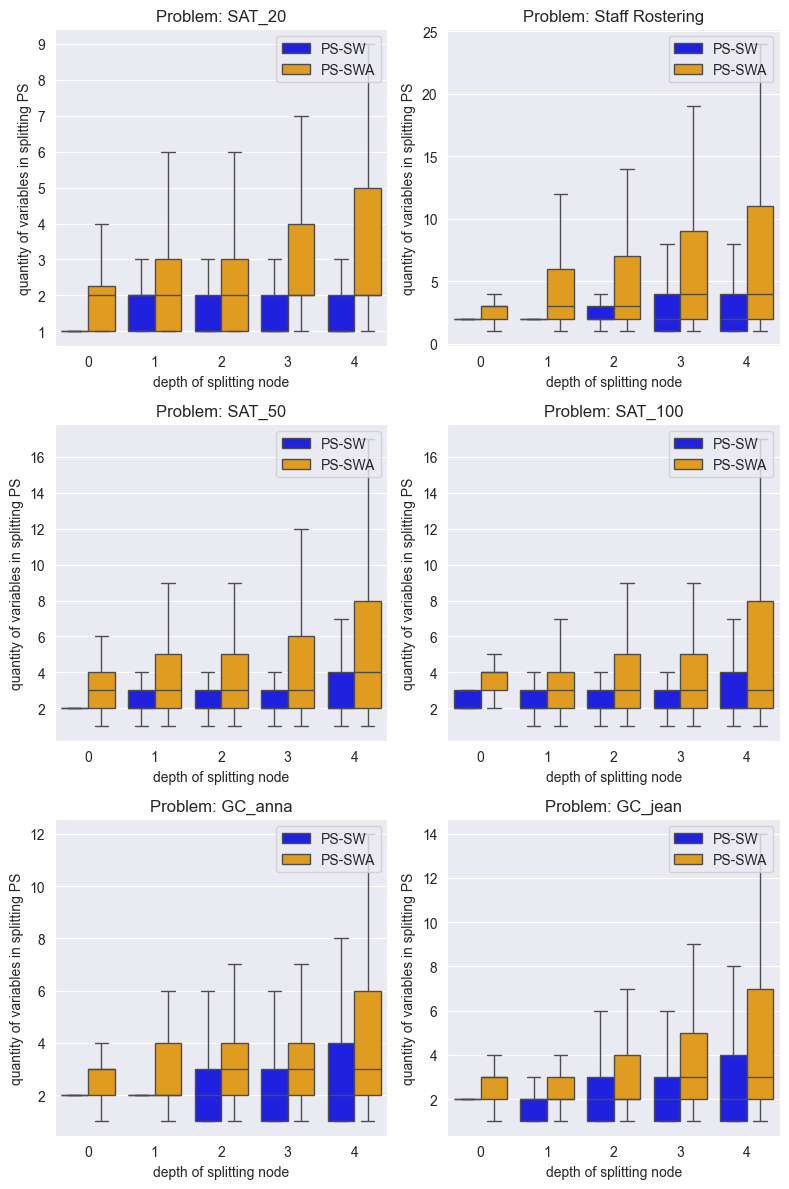

In [9]:
import utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


# Step 3: Create box plots
problems = ["SAT_20", "Staff Rostering", "SAT_50", "SAT_100", "GC_anna", "GC_jean"]
fig, axes = plt.subplots(3, 2, figsize=(2*4, 3*4), sharey=False)

for ax, problem in zip(axes.flatten(), problems):
    valid_data = df[df['problem'] == problem]
    valid_data = valid_data[valid_data['order'] > 0]
    valid_data = valid_data[valid_data['variant'].isin(["PS-SW", "PS-SWA"])]
    #valid_data = df[df['order'] > 0]
    sns.boxplot(
        x='depth', y='order', hue='variant',
        data=valid_data,
        ax=ax, palette={"PS-SW": "blue", "PS-SWA": "orange"},
        showfliers=False
    )
    
    # sns.violinplot(
    #     x='depth', y='order', hue='variant',
    #     data=df[df['problem'] == problem],
    #     ax=ax, palette={"PS-W": "darkgrey", "PS-WA": "lightgrey"},
    #     split=True
    # )
    ax.set_title(f'Problem: {problem}')
    ax.set_ylabel("quantity of variables in splitting PS")
    ax.set_xlabel("depth of splitting node")
    #ax.set_yscale('log', base=2)
    ax.legend(loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()


plt.savefig(os.path.join(run_directory, "boxplots", r"boxplot"+utils.get_formatted_timestamp()+".pdf"))    

plt.show()

In [8]:
run_directory

'C:\\Users\\gac8\\Desktop\\CondorResults\\VDT\\compareown\\all_final_runs'